In [14]:
pip install ortools

In [15]:
pip install matplotlib

Waktu penyelesaian optimal (makespan): 25

Job A:
  - Task 0 (Machine 0): Start at 0, End at 5
  - Task 1 (Machine 2): Start at 5, End at 8
  - Task 2 (Machine 3): Start at 8, End at 15
  - Task 3 (Machine 1): Start at 15, End at 19

Job B:
  - Task 0 (Machine 1): Start at 0, End at 2
  - Task 1 (Machine 2): Start at 8, End at 14
  - Task 2 (Machine 3): Start at 15, End at 23

Job C:
  - Task 0 (Machine 0): Start at 5, End at 9
  - Task 1 (Machine 1): Start at 9, End at 15
  - Task 2 (Machine 2): Start at 15, End at 23
  - Task 3 (Machine 3): Start at 23, End at 25



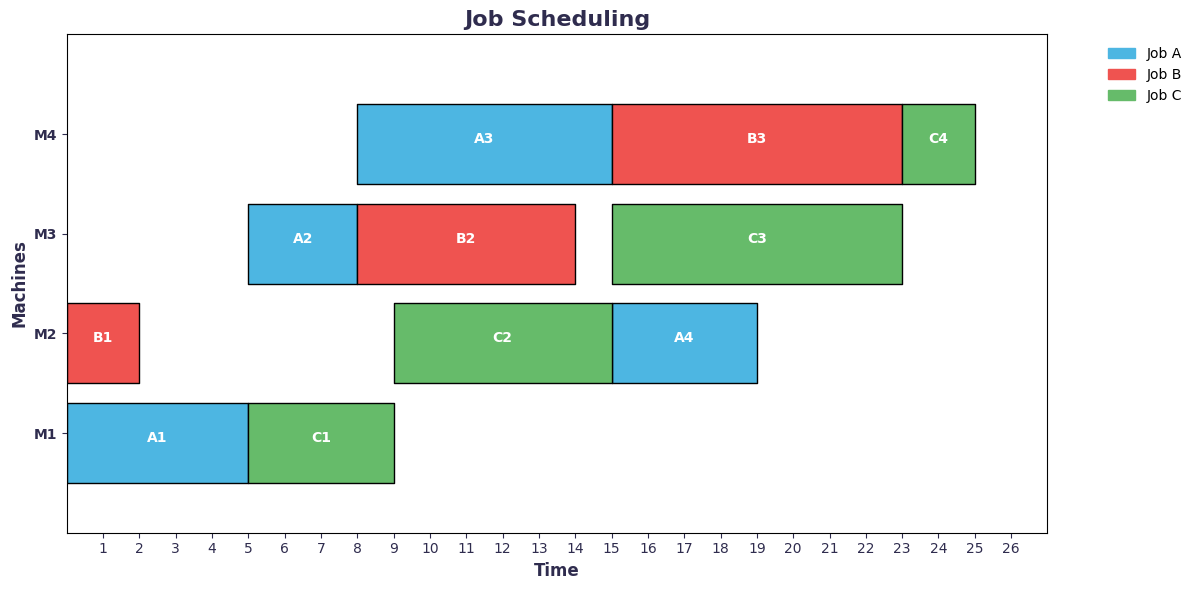

In [16]:
from ortools.sat.python import cp_model
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def main():
    jobs_data = [
        [(0, 5), (2, 3), (3, 7), (1, 4)],  # Job A
        [(1, 2), (2, 6), (3, 8)],           # Job B
        [(0, 4), (1, 6), (2, 8), (3, 2)]    # Job C
    ]

    # Inisialisasi model
    model = cp_model.CpModel()

    num_machines = 4
    job_names = ["A", "B", "C"]
    num_jobs = len(jobs_data)
    all_machines = range(num_machines)

    all_tasks = {}
    machine_to_intervals = {machine: [] for machine in all_machines}

    # Membuat variabel untuk setiap pekerjaan dan operasi
    horizon = sum(task[1] for job in jobs_data for task in job)
    for job_id, job in enumerate(jobs_data):
        for task_id, (machine, duration) in enumerate(job):
            start_var = model.NewIntVar(0, horizon, f'start_{job_id}_{task_id}')
            end_var = model.NewIntVar(0, horizon, f'end_{job_id}_{task_id}')
            interval_var = model.NewIntervalVar(start_var, duration, end_var, f'interval_{job_id}_{task_id}')
            all_tasks[(job_id, task_id)] = (start_var, end_var, interval_var)
            machine_to_intervals[machine].append(interval_var)

    # Membatasi agar tiap mesin hanya menjalankan satu pekerjaan dalam satu waktu
    for machine in all_machines:
        model.AddNoOverlap(machine_to_intervals[machine])

    # Membatasi urutan operasi dalam setiap pekerjaan
    for job_id, job in enumerate(jobs_data):
        for task_id in range(len(job) - 1):
            model.Add(all_tasks[(job_id, task_id)][1] <= all_tasks[(job_id, task_id + 1)][0])

    # Membuat variabel untuk waktu selesai semua pekerjaan (makespan)
    obj_var = model.NewIntVar(0, horizon, 'makespan')
    model.AddMaxEquality(obj_var, [all_tasks[(job_id, len(job) - 1)][1] for job_id, job in enumerate(jobs_data)])
    model.Minimize(obj_var)

    # Pemecahan
    solver = cp_model.CpSolver()
    status = solver.Solve(model)

    # Menampilkan hasil jika solusi optimal ditemukan
    if status == cp_model.OPTIMAL:
        makespan = solver.Value(obj_var)
        print(f'Waktu penyelesaian optimal (makespan): {makespan}\n')
        for job_id, job in enumerate(jobs_data):
            job_name = job_names[job_id]
            print(f"Job {job_name}:")
            for task_id, (machine, duration) in enumerate(job):
                start = solver.Value(all_tasks[(job_id, task_id)][0])
                end = solver.Value(all_tasks[(job_id, task_id)][1])
                print(f"  - Task {task_id} (Machine {machine}): Start at {start}, End at {end}")
            print()

        # Data untuk Gantt Chart
        tasks = []
        for job_id, job in enumerate(jobs_data):
            for task_id, (machine, duration) in enumerate(job):
                start = solver.Value(all_tasks[(job_id, task_id)][0])
                tasks.append((job_id, task_id, machine, start, duration))

        # Membuat Gantt Chart
        fig, gnt = plt.subplots(figsize=(12, 6))
        gnt.set_title('Job Scheduling', fontsize=16, weight='bold', color="#2F2C4E")
        gnt.set_xlabel('Time', fontsize=12, weight='bold', color="#2F2C4E")
        gnt.set_ylabel('Machines', fontsize=12, weight='bold', color="#2F2C4E")

        # Label untuk sumbu y dan waktu
        gnt.set_yticks([10 + i * 10 for i in range(num_machines)])
        gnt.set_yticklabels([f'M{machine + 1}' for machine in range(num_machines)], color="#2F2C4E", weight="bold")
        gnt.set_xticks(range(1, makespan + 2))
        gnt.tick_params(axis='x', colors="#2F2C4E")
        gnt.tick_params(axis='y', colors="#2F2C4E")

        # Batas sumbu
        gnt.set_ylim(0, 10 * num_machines + 10)
        gnt.set_xlim(0, makespan + 2)
        gnt.grid(visible=False)

        # Warna khusus untuk setiap pekerjaan
        colors = ['#4DB6E2', '#EF5350', '#66BB6A']  # Warna untuk job A, B, C

        for job_id, task_id, machine, start, duration in tasks:
            color = colors[job_id % len(colors)]
            label = f'{job_names[job_id]}{task_id+1}'
            gnt.broken_barh([(start, duration)], ((machine * 10) + 5, 8), facecolors=color, edgecolor='black')
            gnt.text(
                start + duration / 2,
                (machine * 10) + 9.5,
                label,
                ha='center',
                va='center',
                color='white',
                fontsize=10,
                weight='bold'
            )

        patches = [mpatches.Patch(color=colors[i], label=f'Job {job_names[i]}') for i in range(len(job_names))]
        plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.15, 1), fontsize=10, frameon=False)

        plt.tight_layout()
        plt.show()
    else:
        print("Solusi optimal tidak ditemukan.")

if __name__ == '__main__':
    main()